Reproducing Prochaska et al 2006 Fig. 2

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scy
from astropy import convolution
import numpy.ma as ma
from scipy.optimize import curve_fit, least_squares
from scipy.integrate import quad
from astropy.io import fits
import CogFunctions as cog


In [11]:
#before continuing create a model with cog_model.py it is a big grid and runs quite osme time

In [4]:
### read in the model

model_cube = fits.open('model.fits')   #in the model LF is in cm , numbers in the name refer to the density of N and b
Model_array = model_cube[0].data

#this is the grid corresponding to the model - you can create your own model with cog_model.py
### the banana plot, error estimation 
N = np.arange(10,20,.01)#logN 10 - 20 
b = np.arange(5,100,.1)  # 5 -100
LF_m = np.linspace(-8,-4,100)

In [12]:
#Iron data from the paper

feii=np.array([[2249.887,-2.7397,112.9,6.8],[2260.780,-2.6126, 155.1,6.5],
               [2344.214,-0.9431,985.6,9.5], [2374.461,-1.5045, 569, 7.9], 
               [2586.65, -1.1605, 916.4, 7.9], [2600.173, -0.6216, 1523.8, 7.8]])


Text(0, 0.5, 'log$_{10}(W_{\\lambda} / \\lambda$)')

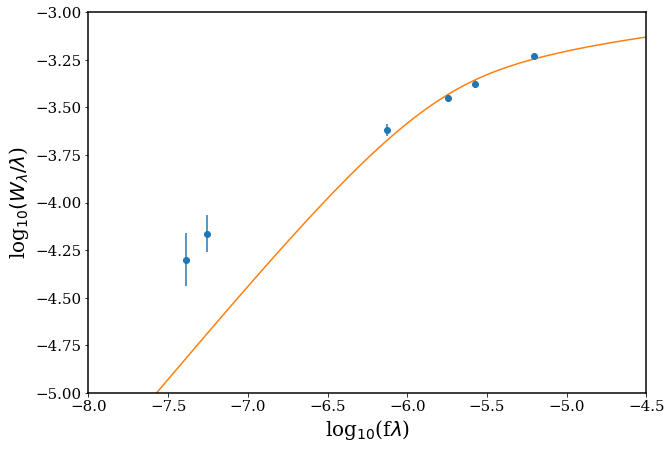

In [23]:
y = feii.T[2]/1000/feii.T[0] #convert the W to mA y = W/lambda

yerr = feii.T[3]/1000/feii.T[0]
yerr = yerr/y /0.434 #scaling becasue of logarithms

x=feii.T[1]+np.log10(feii.T[0]*1e-8) #x = f lambda (lambda in cm)

# values from the paper
Nfe=14.63
b=55
plt.errorbar(x,np.log10(y), yerr=abs(yerr), fmt='o')

lf = np.linspace(-8,-1, 1000)
W = cog.CoG_full(Nfe,b,lf)

plt.plot(lf,np.log10(W))

plt.xlim([-8.0, -4.5])
plt.ylim([-5.0, -3.0])
plt.xlabel(r"log$_{10}$(f$\lambda$)", fontsize=20)
plt.ylabel(r"log$_{10}(W_{\lambda} / \lambda$)", fontsize=20)

In [57]:
### Defining the model grid for COG "banana plot"
N = np.arange(10,20,0.02)#logN 10 - 20 
b = np.arange(5,100,1)  # 5 -100
LF_m = np.linspace(-8,-4,100)
print(np.size(b), np.size(N))

95 500


Here you have to create the model using cog-model.py. It is a large grid and it takes a while to creat it (hence I cannot attach it). Make sure that model has the same parameters like the ranges defined above.

In [58]:
#read the model
model_cube = fits.open('model.fits')

Model_array = model_cube[0].data
print(np.shape(Model_array))
print(np.shape(Model_array)[2])

(100, 95, 500)
500


In [61]:
# sefining the  data (it is basically the same as for the plot above)

w0 = feii.T[2]/1000/feii.T[0]
w0_err = 30./1000/feii.T[0]
lf = feii.T[1]+np.log10(feii.T[0]*1e-8)
print(feii.T[2], feii.T[0])

[ 112.9  155.1  985.6  569.   916.4 1523.8] [2249.887 2260.78  2344.214 2374.461 2586.65  2600.173]


In [62]:
#calculate the chi^2 between the model grid and your measurements

S = np.zeros((np.shape(Model_array)[2],np.shape(Model_array)[1]))
L =np.zeros((np.shape(Model_array)[2],np.shape(Model_array)[1]))
for i in range(np.shape(Model_array)[2]):

    for j in range(np.shape(Model_array)[1]):
        s_sum=0
   
        for w,s, l in zip(w0, w0_err, lf):
            #print(w,s)
            #find the lf in the model closest to the datapoint
            delta_l = np.abs(LF_m - l) 
            idx = np.argmin(delta_l)
            #print(idx)
            model = Model_array[idx][j][i] # model index lf, b, N
            
            #print(l, LF_m[idx])
            s_k = (w - 10**model)**2/(s)**2

          
            s_sum+=s_k

        S[i][j] = s_sum
        L[i][j] = np.exp(-s_sum/2.)
        
S_min = np.min(S)

Chi_r =S/(np.size(w0)-2) #reduced Chi^2, you can also used just Chi^2, which is just S
print("Minimal Chi^2",np.min(Chi_r))

Minimal Chi^2 8.773517187754779


In [63]:
#Find the best values for N and b
index = np.where(Chi_r == np.min(Chi_r))
min_chi=np.min(Chi_r)
print(index, b[50])
nbest,bbest = N[index[0]], b[index[1]]
nbest=round(nbest[0],2)
bbest = round(bbest[0],2)
print("N_best = ", nbest, "b_best = ", bbest)

(array([232]), array([50])) 55
N_best =  14.64 b_best =  55


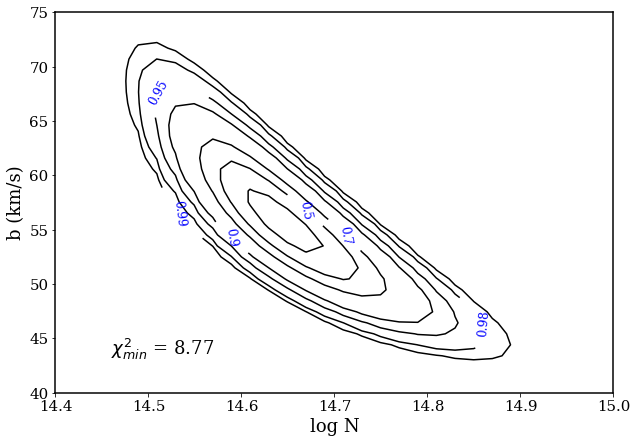

In [64]:
#error estimation - banana plot
xlim, ylim =[14.4,15], [40,75] #set the liits of the plot manually
cog.banana_plot(Chi, xlim=xlim, ylim=ylim)

52 55 58 -3 3
14.6 14.64 14.68 -0.040000000000000924 0.03999999999999915
b = 55$\pm$ (3,3)
log(N) = 14.64$\pm$ (0.04,0.04)


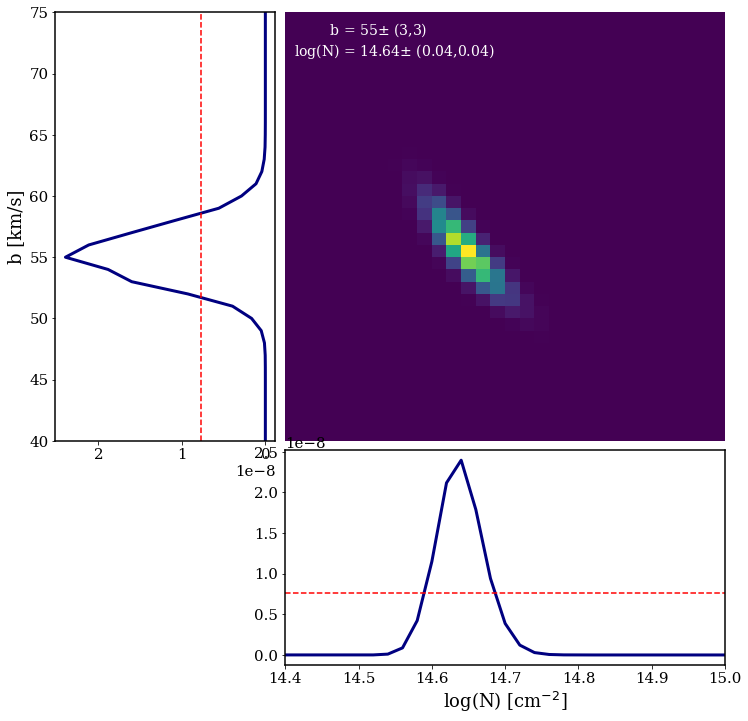

In [67]:
#I didn't mange to make a function out of this
# plot the values distribution and calculate errors
Lmax = np.max(L)
fig = plt.figure(figsize=(12,12))

gs = GridSpec(2, 2, width_ratios=[1, 2], height_ratios=[2, 1], hspace=0.03, wspace=0.03)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
#ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])


ax2.imshow(L.T,origin='lower', extent=(10,20,5,100),aspect='auto' )
ax2.axis('off')
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
#plt.colorbar()
#plt.contour(L.T, levels=[Lmax*0.01,Lmax*0.1, Lmax*0.32 ], extent=(10,20,5,100),colors='red')

X, Y = np.array([]),np.array([])
for i in range(np.size(L[0])):
    X = np.append(X, np.max(L.T[i]))
for j in range(np.size(L.T[0])):
    Y = np.append(Y, np.max(L.T[:,j]))

sigmaX, sigmaY = np.std(X), np.std(Y)

ax1.plot(X, b, c='navy', lw=3)
ax1.set_ylim(ylim)
ax1.axvline(0.32*Lmax, ls='--', c='r')

ax1.set_ylabel("b [km/s]")
ax1.invert_xaxis()
ax4.plot(N, Y, c='navy', lw=3)
ax4.set_xlim(xlim)
ax4.set_xlabel(r'log(N) [cm$^{-2}$]')
ax4.axhline(0.32*Lmax, ls='--', c='r')

#estmate limits - 1 sigma range
#it is switched between b and n becasue we are plotting L.T (so back to the original N and b arrays we have to transpose)
ni=np.where(Y >= 0.32*Lmax) # all larger the 1 sigma confidence
bi = np.where(X >= 0.32*Lmax)


bmin, bmax = round(np.min(b[bi]),2), round(np.max(b[bi]),2)
nmin, nmax = round(np.min(N[ni]),2), round(np.max(N[ni]),2)
print(bmin, bbest, bmax, bmin-bbest,bmax-bbest)
print(nmin,nbest, nmax, nmin-nbest, nmax-nbest)
bdo, bup = round(-bmin+bbest,2), round(bmax-bbest,2)
ndo, nup = round(-nmin+nbest,2), round(nmax-nbest,2)

ax2.annotate("        b = " + str(bbest) + r"$\pm$ ("+str(bup)+','+str(bdo)+")\nlog(N) = "+str(nbest) +r"$\pm$ ("+str(nup)+','+str(ndo)+")"  , (0.02, 0.9),xycoords='axes fraction', c='white', fontsize=14)


result= "b = " + str(bbest) + r"$\pm$ ("+str(bup)+','+str(bdo)+")\nlog(N) = "+str(nbest) +r"$\pm$ ("+str(nup)+','+str(ndo)+")"
print(result)


